# Fallback - Insert Retention Scores
* StelllarAlgo Data Science
* Ryan Kazmerik, Grant Donst
* Sept 12, 2022

In [1]:
import boto3
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *
from shared_utilities import helpers

/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
if not boto3.DEFAULT_SESSION:
    ! aws sso login --profile Stellaralgo-DataScienceAdmin
    session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

HZCN-RXBT
Successfully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [3]:
LKUPCLIENTID = 101
MSSQL_DB = "stlrCFLRedblacks"
CNXN = helpers.get_mssql_connection("PROD", MSSQL_DB)

In [4]:
try:
    cursor = CNXN.cursor()

    storedProc = (
        f"""Exec {MSSQL_DB}.[ds].[getRetentionScoringModelData] {LKUPCLIENTID}"""
    )

    df = pd.read_sql(storedProc, CNXN)

    # apply some data transformations
    df["year"] = pd.to_numeric(df["year"])

    CNXN.commit()
    cursor.close()

    df.shape

except Exception as err:
    print("ERROR INSERTING RETENTION SCORES TO DATABASE:", err)
    cursor.execute("ROLLBACK")

In [5]:
df.year.value_counts()

2022    5372
2021    3278
2018    2964
2019    2488
Name: year, dtype: int64

In [6]:
df.head()

,lkupClientId,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,source_tenure,tenure,distToVenue,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,click_link,fill_out_form,open_email,send_email,unsubscribe_email,openToSendRatio,clickToSendRatio,clickToOpenRatio,posting_records,resale_records,resale_atp,forward_records,cancel_records,email,inbound_email,inbound_phonecall,inperson_contact,internal_note,left_message,outbound_email,outbound_phonecall,phonecall,text,unknown,gender,childrenPresentInHH,maritalStatus,lengthOfResidenceInYrs,annualHHIncome,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer
0,101,19,2018,Full Season,1481.4,2018-10-19,0.750000,0,TRUE,0,134,None,6,0,2,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,0.0,0,9,None,1
1,101,33,2018,Full Season,926.1,2018-11-02,0.833333,0,TRUE,0,134,None,9,0,2,1,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,0.0,0,9,None,1
2,101,56,2018,Full Season,705.6,2018-10-19,1.000000,0,TRUE,0,134,None,8,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,0.0,0,9,None,0
3,101,63,2018,Full Season,720.0,2018-10-19,0.937500,0,TRUE,0,134,None,8,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,0.0,0,9,None,0
4,101,100,2018,Full Season,1876.5,2018-11-02,1.000000,0,TRUE,0,134,None,9,0,2,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,0.0,0,9,None,0


### We should specify the features used in our model:

In [7]:
# choose the features for the stellar base retention model
features = [
    "attendancePercent",
    "dimCustomerMasterId",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "missed_games_1",
	"missed_games_2",
	"missed_games_over_2",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (7420, 14)
Unseen Data For Predictions: (1310, 14)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [8]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentDate"
    ],
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "missed_games_1",
	    "missed_games_2",
	    "missed_games_over_2",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [9]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","rf","xgboost"],
    n_select=5,
    probability_threshold= 0.75
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.6725,0.8077,0.5579,0.8309,0.6670,0.3685,0.3975,0.0990
lightgbm,Light Gradient Boosting Machine,0.6605,0.8107,0.5165,0.8473,0.6413,0.3535,0.3932,0.1670
rf,Random Forest Classifier,0.6600,0.7695,0.5644,0.7988,0.6612,0.3399,0.3607,0.2150
gbc,Gradient Boosting Classifier,0.5909,0.7979,0.3669,0.8572,0.5125,0.2480,0.3159,1.0550
lr,Logistic Regression,0.4486,0.6719,0.1158,0.6917,0.1981,0.0345,0.0680,0.1690


In [10]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4437,0.6627,0.1186,0.6471,0.2005,0.0224,0.0417
1,0.4437,0.6448,0.1051,0.6724,0.1818,0.0272,0.0546
2,0.4691,0.6807,0.1429,0.7571,0.2404,0.0660,0.1214
3,0.4485,0.6997,0.1159,0.6825,0.1982,0.0331,0.0640
4,0.4374,0.6731,0.1022,0.6441,0.1763,0.0178,0.0356
5,0.4374,0.6550,0.1129,0.6269,0.1913,0.0139,0.0262
6,0.4540,0.6581,0.1267,0.7015,0.2146,0.0420,0.0789
7,0.4683,0.6926,0.1267,0.8103,0.2191,0.0712,0.1433
8,0.4540,0.7289,0.0997,0.7872,0.1770,0.0514,0.1145


### Let's load in our 2021 season data and get retention scores using the model:

In [11]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(8650, 14)

In [12]:
predictions = []
for idx, final_m in enumerate(models):
    
    df_predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]
    final_m["predictions"] = df_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7086,0.7148,0.5668,0.3320,0.4187,0.2416,0.2570


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7554,0.7324,0.4850,0.3757,0.4234,0.2714,0.2749


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8229,0.8312,0.7022,0.5161,0.5949,0.4850,0.4944


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7504,0.6982,0.3602,0.3372,0.3483,0.1942,0.1943


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7776,0.7322,0.0543,0.1754,0.0829,-0.0051,-0.0062


### We can create some histograms to visualize each model distribution:

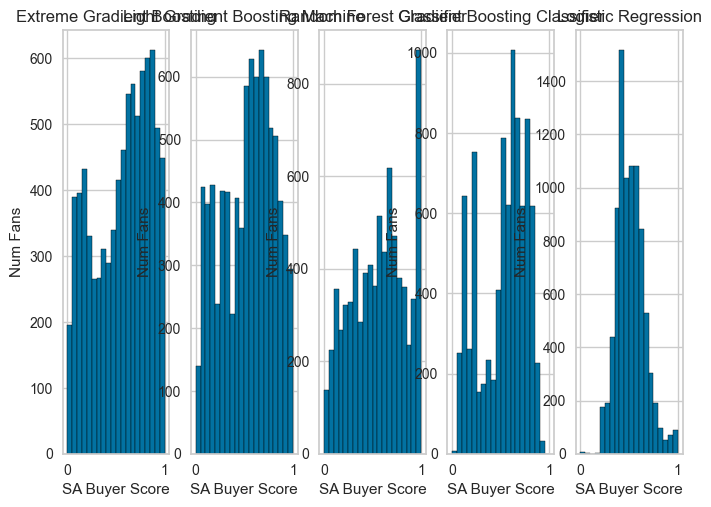

In [13]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 5, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [14]:
for idx, model in enumerate(models):
    print(models[idx]["predictions"]["Label"].value_counts())


0    5711
1    2735
Name: Label, dtype: int64
0    6506
1    2068
Name: Label, dtype: int64
0    5561
1    2180
Name: Label, dtype: int64
0    6939
1    1711
Name: Label, dtype: int64
0    8133
1     496
Name: Label, dtype: int64


### Select the model you would like to use for updating scores:

In [15]:
selected_model = "Light Gradient Boosting Machine"

for model in models:
    if model["name"] == selected_model:
        df_scores = model["predictions"]
                                 
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8574 entries, 5452 to 14101
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   attendancePercent    8574 non-null   float64
 1   dimCustomerMasterId  8574 non-null   int64  
 2   distToVenue          8574 non-null   int64  
 3   isNextYear_Buyer     8574 non-null   int64  
 4   lkupClientId         8574 non-null   int64  
 5   missed_games_1       8574 non-null   int64  
 6   missed_games_2       8574 non-null   int64  
 7   missed_games_over_2  8574 non-null   int64  
 8   productGrouping      8574 non-null   object 
 9   recency              8574 non-null   int64  
 10  recentDate           8574 non-null   object 
 11  source_tenure        8574 non-null   int64  
 12  totalSpent           8574 non-null   float64
 13  year                 8574 non-null   int64  
 14  Label                8574 non-null   int64  
 15  Score_0              8574 non-null

### Optionally we can push these scores into QA so that we can see what the new scoring looks like in the CDP:

In [18]:
DBNAME = "stlrcflredblacks"
CONN = helpers.get_redshift_connection("qa-app-elbu", DBNAME)

### Insert the scores into the customerretentionscores table in RedShift:

In [19]:
cur = CONN.cursor()

batch_size = 100
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE: {DBNAME} ({LKUPCLIENTID})")

fields = f"""
INSERT INTO {DBNAME}.dw.customerretentionscores (
    attendancePercentage,
    dimcustomermasterid,
    scoredate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonyear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancePercent)},
                {str(row.dimCustomerMasterId)},
                '{str(datetime.now().strftime("%Y-%m-%d"))}',
                {str(row.lkupClientId)},
                '{str(row.recentDate)}',
                '{str(row.productGrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    cur.execute(insert_statement)
    CONN.commit()

    count = cur.rowcount
        
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 8629 NEW RETENTION SCORES TO DATABASE: stlrcflredblacks (101)
 > INSERTED BATCH 1 : ROWS 1 - 100
 > INSERTED BATCH 2 : ROWS 101 - 200
 > INSERTED BATCH 3 : ROWS 201 - 300
 > INSERTED BATCH 4 : ROWS 301 - 400
 > INSERTED BATCH 5 : ROWS 401 - 500
 > INSERTED BATCH 6 : ROWS 501 - 600
 > INSERTED BATCH 7 : ROWS 601 - 700
 > INSERTED BATCH 8 : ROWS 701 - 800
 > INSERTED BATCH 9 : ROWS 801 - 900
 > INSERTED BATCH 10 : ROWS 901 - 1000
 > INSERTED BATCH 11 : ROWS 1001 - 1100
 > INSERTED BATCH 12 : ROWS 1101 - 1200
 > INSERTED BATCH 13 : ROWS 1201 - 1300
 > INSERTED BATCH 14 : ROWS 1301 - 1400
 > INSERTED BATCH 15 : ROWS 1401 - 1500
 > INSERTED BATCH 16 : ROWS 1501 - 1600
 > INSERTED BATCH 17 : ROWS 1601 - 1700
 > INSERTED BATCH 18 : ROWS 1701 - 1800
 > INSERTED BATCH 19 : ROWS 1801 - 1900
 > INSERTED BATCH 20 : ROWS 1901 - 2000
 > INSERTED BATCH 21 : ROWS 2001 - 2100
 > INSERTED BATCH 22 : ROWS 2101 - 2200
 > INSERTED BATCH 23 : ROWS 2201 - 2300
 > INSERTED BATCH 24 : ROWS 2301 - 240